In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='./datasets/MNIST/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./datasets/MNIST/', train=False, download=True, transform=transform)

In [2]:
# create training and test dataloaders
num_workers = 0
batch_size = 128

# prepare dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

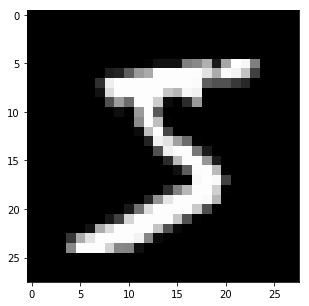

In [3]:
# do some visualization
import matplotlib.pyplot as plt
%matplotlib inline

# get one batch of training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy()

one_image = np.squeeze(images[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(one_image, cmap='gray')

In [4]:
# initialize a nn
from conv_autoencoder import ConvAutoencoder

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(2, 4, kernel_size=(3, 3), stride=(3, 3))
  (t_conv2): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [5]:
import torch.nn as nn

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
# we just train fixed number of epochs
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = 0.
    
    for data in train_dataloader:
        images, _ = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
    train_loss = train_loss / len(train_dataloader)
    print('Epoch: {}/{} \t\t Training loss: {:.6f}'.format(epoch+1, n_epochs, train_loss))

Epoch: 1/10 		 Training loss: 11.219569
Epoch: 2/10 		 Training loss: 8.343970
Epoch: 3/10 		 Training loss: 8.083384
Epoch: 4/10 		 Training loss: 8.033862Epoch: 5/10 		 Training loss: 7.994408
Epoch: 6/10 		 Training loss: 7.969026
Epoch: 7/10 		 Training loss: 7.959006
Epoch: 8/10 		 Training loss: 7.937742
Epoch: 9/10 		 Training loss: 7.932563
Epoch: 10/10 		 Training loss: 7.923858


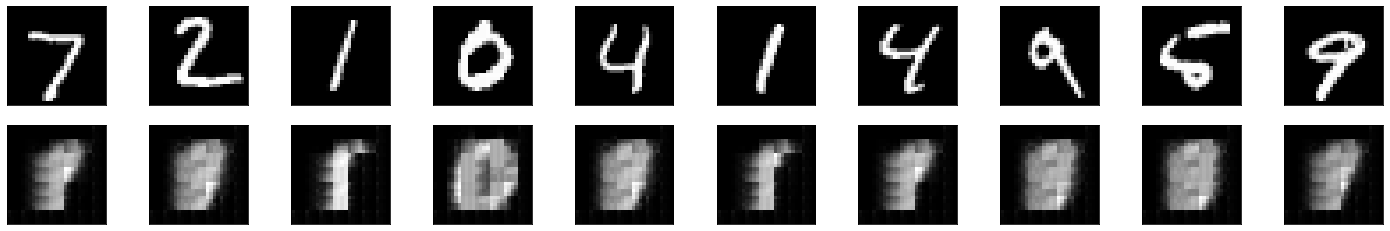

In [7]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [8]:
# save current model for easy reproduce
torch.save(model.state_dict(), 'outputs/mnist/models/mnist_convae_epoch_10.pth')

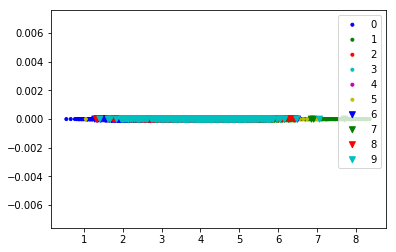

In [12]:
from visualization import visualize
# do 2-dim visualization
dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
num_examples = 5000

labels = []
X = []
# encode images to form 2-dim data
for i, data in enumerate(dataloader):
    img, label = data
    two_dim_encode = model.encode(img)
    X.append(two_dim_encode.detach().numpy().reshape(2,))
    labels.append(label)
    if i >= num_examples:
        break
visualize(data=X, label=labels)